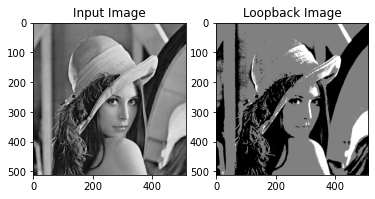

In [1]:
from pynq import Overlay, allocate
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the overlay
overlay = Overlay("gray2.bit")

# Initialize DMA
dma = overlay.axi_dma_0

# Load the grayscale image using PIL
img = Image.open('g.png').convert('L')  # Convert to grayscale
image = np.array(img, dtype=np.uint8)  # Convert the image to a numpy array

# Flatten the image (since we are streaming pixel by pixel)
image_flattened = image.flatten()

# Chunking size (choose a size smaller than the maximum DMA buffer size limit)
chunk_size = 16383  # Maximum size that can be transferred in one go

# Allocate buffers
input_buffer = allocate(shape=(chunk_size,), dtype=np.uint8)
output_buffer = allocate(shape=(chunk_size,), dtype=np.uint8)

# Total number of chunks
num_chunks = (len(image_flattened) + chunk_size - 1) // chunk_size

# Output image placeholder
output_image_flattened = np.zeros_like(image_flattened)

# Process each chunk

for i in range(num_chunks):
    start = i * chunk_size
    end = min(start + chunk_size, len(image_flattened))

    # Load the current chunk into the input buffer
    np.copyto(input_buffer[:end-start], image_flattened[start:end])
    
    # Send the current chunk to PL through DMA
    dma.sendchannel.transfer(input_buffer[:end-start])
#     dma.sendchannel.wait()
    
    # Receive the processed chunk from PL
    dma.recvchannel.transfer(output_buffer[:end-start])
#     dma.recvchannel.wait()
    
    # Store the received chunk in the output image array
    output_image_flattened[start:end] = output_buffer[:end-start]

# Reshape the flattened output buffer into the original image shape
output_image = output_image_flattened.reshape(image.shape)

# Display the input and output images
plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Loopback Image')
plt.imshow(output_image, cmap='gray')

plt.show()

# Free the buffers
input_buffer.freebuffer()
output_buffer.freebuffer()
